Symbolic Result Matrix:
⎡                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                                     0.2000000000 ↪
⎢               1.0         0.333333333333333⋅(-2.0⋅θᵥₐᵣ⋅cos(ρᵥₐᵣ) + 3.0⋅sin(aᵥₐᵣ))                ↪
⎢1.0e-10 + ────────────── + ─────────────────────────────────────────────────────── + ──────────── ↪
⎢          θᵥₐᵣ + 1.0e-10                                      2                                   ↪
⎢                                              (θᵥₐᵣ + 1.0e-10)                                    ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                  

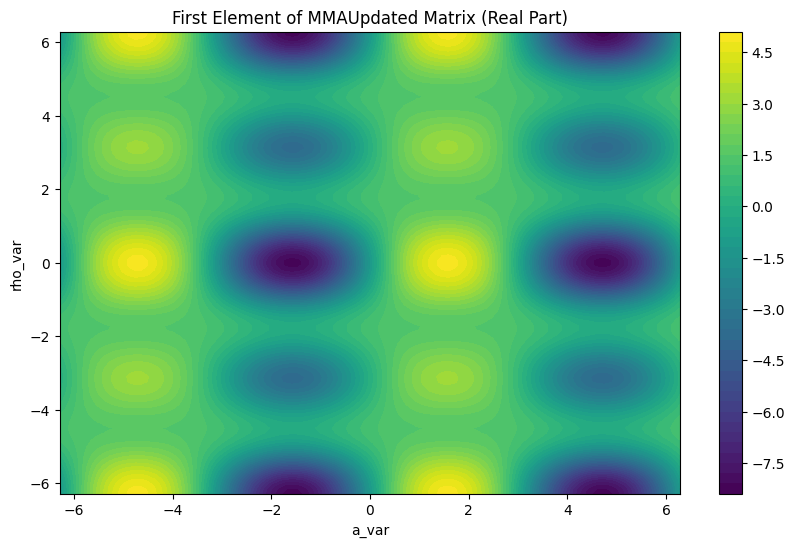

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define symbols
nu_E = 1e-10  # Small constant to avoid zero division

alpha_var, rho_var, theta_var, eta_var = sp.symbols('a_var rho_var theta_var eta_var', real=True)
x = sp.Matrix([sp.Symbol('x1', real=True), sp.Symbol('x2', real=True)])

# Example expressions for alpha, rho, theta, eta
alpha_expr = sp.sin(alpha_var)
rho_expr = sp.cos(rho_var)
theta_expr = theta_var
eta_value = eta_var

# Function to safeguard logarithm computation
def safe_log(expr):
    # Adding a small value (nu_E) so the argument of log is not zero or negative
    return sp.log(sp.Abs(expr) + nu_E)

# Define the MMAUpdated function
def MMAUpdated(x, alpha, rho, theta, eta):
    phi = sp.Matrix([sp.diff(alpha, xi) + sp.diff(rho, xi) + eta * sp.diff(alpha, xi) for xi in x])
    sigma = safe_division(sp.Float(1.0), theta)
    omega = -2.0 * rho

    phi_diff = sp.Matrix([
        [sp.diff(phi[i], xi) for xi in x]
        for i in range(len(phi))
    ])
    phi_diff_3 = phi_diff.applyfunc(lambda elem: elem**3 if not elem.is_zero else nu_E)

    target_shape = (len(x), len(x))

    term1 = expand_to_shape(sigma * FactorChiMatrix(phi), target_shape)
    term2 = expand_to_shape(sigma**2 / 3.0 * (3.0 * alpha + omega * theta) * FactorChiMatrix(phi_diff), target_shape)
    term3 = expand_to_shape(sigma**3 / 5.0 * (5.0 * alpha * omega**2 + safe_division(omega, rho) * (alpha + omega * theta)**2) * FactorChiMatrix(phi_diff_3), target_shape)

    phi_trace = phi.trace() if phi.shape[0] == phi.shape[1] else sum([phi[i, i] for i in range(min(phi.shape))])
    term4 = expand_to_shape(sp.I * sigma**2 * phi_trace * sp.ones(target_shape[0], target_shape[1]), target_shape)
    log_arg = rho + 0.5 * theta * alpha + nu_E
    term5 = expand_to_shape(sp.I * sigma**3 / 6.0 * safe_log(log_arg), target_shape)
    term6 = expand_to_shape(phi_diff.applyfunc(lambda elem: sigma**4 / 2.0 * elem**4 if not elem.is_zero else nu_E), target_shape)

    TrU = term1 + term2 + term3 + term4 + term5 + term6

    return TrU

def FactorChiMatrix(expr):
    if isinstance(expr, sp.Matrix):
        return expr.applyfunc(lambda e: sp.exp(sp.simplify(e)))
    else:
        return sp.exp(sp.simplify(expr))

def safe_division(num, denom):
    """Safeguards division to avoid ZeroDivisionError by replacing zero with nu_E."""
    return num / (denom + nu_E)

def expand_to_shape(mat, target_shape):
    """Expands the matrix `mat` by padding with zeros to match the `target_shape`."""
    if not isinstance(mat, sp.Matrix):
        mat = sp.Matrix([[mat]])  # Convert scalar to matrix
    expanded_matrix = sp.zeros(*target_shape)
    for i in range(min(target_shape[0], mat.shape[0])):
        for j in range(min(target_shape[1], mat.shape[1])):
            expanded_matrix[i, j] = mat[i, j]
    return expanded_matrix

# Compute MMAUpdated for given symbols
mma_result = MMAUpdated(x, alpha_expr, rho_expr, theta_expr, eta_value)

# Print intermediate results for debugging
print("Symbolic Result Matrix:")
sp.pprint(mma_result)

# Convert symbolic expressions to numerical functions using lambdify
symbol_list = [alpha_var, rho_var, theta_var, eta_var]
numeric_funcs = [[sp.lambdify(symbol_list, elem, modules=("numpy", {"nu_E": nu_E})) for elem in row] for row in mma_result.tolist()]

# Define the variables range
a_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
rho_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
theta_vals = np.array([1.0])  # Avoid zero
eta_vals = np.array([0.0])

# Meshgrid for plotting
A, R = np.meshgrid(a_var_vals, rho_var_vals)

# Function to evaluate matrix at given a_var and rho_var
def evaluate_matrix(numeric_funcs, A, R, theta_val, eta_val):
    evaluated_matrix = np.zeros((A.shape[0], A.shape[1], len(numeric_funcs), len(numeric_funcs[0])), dtype=complex)
    for i in range(len(numeric_funcs)):
        for j in range(len(numeric_funcs[i])):
            evaluated_matrix[:, :, i, j] = numeric_funcs[i][j](A, R, theta_val, eta_val)
    return evaluated_matrix

# Evaluate the matrix
evaluated_matrix = evaluate_matrix(numeric_funcs, A, R, theta_vals[0], eta_vals[0])

# Debug: Check evaluated matrix shapes and values
print("Evaluated Matrix Shape:", evaluated_matrix.shape)
print("Evaluated Matrix Values (first element):", evaluated_matrix[:,:,0,0].real[:5,:5])  # Sample for brevity

# Plot the first element as an example
element_vals = evaluated_matrix[:, :, 0, 0].real  # Plotting the real part

plt.figure(figsize=(10, 6))
contour = plt.contourf(A, R, element_vals, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('First Element of MMAUpdated Matrix (Real Part)')
plt.xlabel('a_var')
plt.ylabel('rho_var')
plt.show()

Symbolic Result Matrix:
⎡                                                                                                  ↪
⎢                                                                                                  ↪
⎢     (ηᵥₐᵣ + 1)⋅cos(αᵥₐᵣ)                                                            (-ηᵥₐᵣ - 1)⋅ ↪
⎢1.0⋅ℯ                       0.333333333333333⋅(-2.0⋅θᵥₐᵣ⋅cos(ρᵥₐᵣ) + 3.0⋅sin(αᵥₐᵣ))⋅ℯ             ↪
⎢───────────────────────── + ───────────────────────────────────────────────────────────────────── ↪
⎢     θᵥₐᵣ + 1.0e-10                                                       2                       ↪
⎢                                                          (θᵥₐᵣ + 1.0e-10)                        ↪
⎢                                                                                                  ↪
⎢                                                                                                  ↪
⎢                                                                  

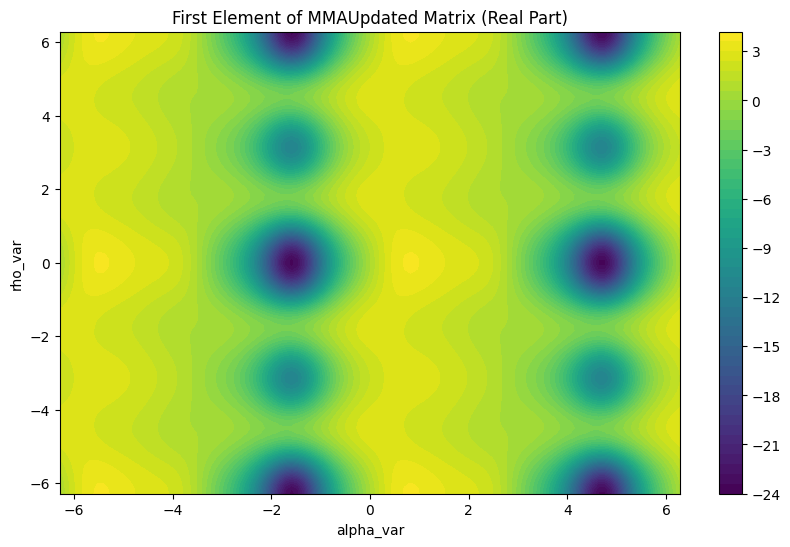

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define symbols
nu_E = 1e-10  # Small constant to avoid zero division

# x now contains the variables with respect to which we'll differentiate
alpha_var, rho_var, theta_var, eta_var = sp.symbols('alpha_var rho_var theta_var eta_var', real=True)
x = sp.Matrix([alpha_var, rho_var])

# Example expressions for alpha, rho, theta, eta
alpha_expr = sp.sin(alpha_var)
rho_expr = sp.cos(rho_var)
theta_expr = theta_var
eta_value = eta_var

# Function to safeguard logarithm computation
def safe_log(expr):
    # Adding a small value (nu_E) so the argument of log is not zero or negative
    return sp.log(sp.Abs(expr) + nu_E)

def FactorChiMatrix(expr):
    if isinstance(expr, sp.Matrix):
        return expr.applyfunc(lambda e: sp.exp(sp.simplify(e)))
    else:
        return sp.exp(sp.simplify(expr))

def safe_division(num, denom):
    """Safeguards division to avoid ZeroDivisionError by replacing zero with nu_E."""
    return num / (denom + nu_E)

def expand_to_shape(mat, target_shape):
    """Expands the matrix `mat` by padding with zeros to match the `target_shape`."""
    if not isinstance(mat, sp.Matrix):
        mat = sp.Matrix([[mat]])  # Convert scalar to matrix
    expanded_matrix = sp.zeros(*target_shape)
    for i in range(min(target_shape[0], mat.shape[0])):
        for j in range(min(target_shape[1], mat.shape[1])):
            expanded_matrix[i, j] = mat[i, j]
    return expanded_matrix

# Define the MMAUpdated function
def MMAUpdated(x, alpha, rho, theta, eta):
    phi = sp.Matrix([sp.diff(alpha, xi) + sp.diff(rho, xi) + eta * sp.diff(alpha, xi) for xi in x])
    sigma = safe_division(sp.Float(1.0), theta)
    omega = -2.0 * rho

    phi_diff = sp.Matrix([
        [sp.diff(phi[i], xi) for xi in x]
        for i in range(len(phi))
    ])
    phi_diff_3 = phi_diff.applyfunc(lambda elem: elem**3 if not elem.is_zero else nu_E)

    target_shape = (len(x), len(x))

    term1 = expand_to_shape(sigma * FactorChiMatrix(phi), target_shape)
    term2 = expand_to_shape(sigma**2 / 3.0 * (3.0 * alpha + omega * theta) * FactorChiMatrix(phi_diff), target_shape)
    term3 = expand_to_shape(sigma**3 / 5.0 * (5.0 * alpha * omega**2 + safe_division(omega, rho) * (alpha + omega * theta)**2) * FactorChiMatrix(phi_diff_3), target_shape)

    # Sum over elements of phi to get a scalar value
    phi_trace = sum(phi)  # Modified here
    term4 = expand_to_shape(sp.I * sigma**2 * phi_trace * sp.ones(target_shape[0], target_shape[1]), target_shape)
    log_arg = rho + 0.5 * theta * alpha + nu_E
    term5 = expand_to_shape(sp.I * sigma**3 / 6.0 * safe_log(log_arg), target_shape)
    term6 = expand_to_shape(phi_diff.applyfunc(lambda elem: sigma**4 / 2.0 * elem**4 if not elem.is_zero else nu_E), target_shape)

    TrU = term1 + term2 + term3 + term4 + term5 + term6

    return TrU

# Compute MMAUpdated for given symbols
mma_result = MMAUpdated(x, alpha_expr, rho_expr, theta_expr, eta_value)

# Print intermediate results for debugging
print("Symbolic Result Matrix:")
sp.pprint(mma_result)

# Convert symbolic expressions to numerical functions using lambdify
symbol_list = [alpha_var, rho_var, theta_var, eta_var]
numeric_funcs = [[sp.lambdify(symbol_list, elem, modules=("numpy", {"nu_E": nu_E})) for elem in row] for row in mma_result.tolist()]

# Define the variables range
a_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
rho_var_vals = np.linspace(-2*np.pi, 2*np.pi, 100)
theta_vals = np.array([1.0])  # Avoid zero
eta_vals = np.array([0.0])

# Meshgrid for plotting
A, R = np.meshgrid(a_var_vals, rho_var_vals)

# Function to evaluate matrix at given a_var and rho_var
def evaluate_matrix(numeric_funcs, A, R, theta_val, eta_val):
    evaluated_matrix = np.zeros((A.shape[0], A.shape[1], len(numeric_funcs), len(numeric_funcs[0])), dtype=complex)
    for i in range(len(numeric_funcs)):
        for j in range(len(numeric_funcs[i])):
            evaluated_matrix[:, :, i, j] = numeric_funcs[i][j](A, R, theta_val, eta_val)
    return evaluated_matrix

# Evaluate the matrix
evaluated_matrix = evaluate_matrix(numeric_funcs, A, R, theta_vals[0], eta_vals[0])

# Debug: Check evaluated matrix shapes and values
print("Evaluated Matrix Shape:", evaluated_matrix.shape)
print("Evaluated Matrix Values (first element):", evaluated_matrix[:, :, 0, 0].real[:5, :5])  # Sample for brevity

# Plot the first element as an example
element_vals = evaluated_matrix[:, :, 0, 0].real  # Plotting the real part

plt.figure(figsize=(10, 6))
contour = plt.contourf(A, R, element_vals, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('First Element of MMAUpdated Matrix (Real Part)')
plt.xlabel('alpha_var')
plt.ylabel('rho_var')
plt.show()